In [65]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt 
import acor
import numpy as np
from scipy.stats import norm


# 55) XY Model, Overdamped vs Metropolized

The PDF of the XY model is given by 

$$
\pi(\sigma) = \frac{e^{\beta \sum_{|j - i| = 1} \sigma (i) \cdot \sigma (j)}}{\mathcal{Z}}
$$

For normalization constant $\mathcal{Z}$ and $\sigma(i) = (\sigma_x(i), \sigma_y(i))$ with constraint $||\sigma(i)|| = 1$

To sample from the XY model, it will be simpler to express each point $\sigma(i)$ on the 1 dimensional lattice as angles: $\theta(i) = arctan(\frac{\sigma_y(i)}{\sigma_x(i)})$ The PDF in terms of the angle is 

$$
\pi(\theta) = \frac{e^{\beta \sum_{|j - i| = 1} cos( \theta (i) - \theta(j) )}}{\mathcal{Z}}
$$


## Overdamped)  

The recursive case where 
$$
X^{(k+1)}_h = X^{(k)}_h + h\mathbf{S}\nabla^T\textrm{log}(\pi(X^{(k)}_h)) + \sqrt{2h\mathbf{S}} \xi^{k+1}
$$

Where $X^{(k)}_h = (\theta(1), ..., \theta(L))$ the angles at step $k$, and $\xi^{k+1}$ will be a length $L$ vector of independent gaussians, and $\mathbf{S}$ be the correlation matrix of $\xi$, which in this case is just the identity $\mathbf{I}$. 

The partial of the log density w.r.t. to $\theta(k)$ to some  is given by 

$$
\begin{aligned}
\frac{\partial \textrm{log}(\pi(\theta))}{\partial \theta(k)} 
&= \frac{1}{\pi(\theta)} \frac{\partial \pi(\theta) }{\partial \theta(k)}  \\
&= \frac{1}{\pi(\theta)} \pi(\theta) \frac{\partial \beta \sum_{|j - k| = 1} cos( \theta(k) - \theta(j) ) }{\partial \theta(k)}  \\
&= \beta \sum_{|j - k| = 1} -sin( \theta(k) - \theta(j) )  
\end{aligned} 
$$

Note that here k is fixed, so $\sum_{|j - k| = 1} f_j = \sum_{j = 1}^L f_j \mathbb{1}(|j - k| = 1)$ for some function $f_j$. This is only the left and right neighbors of point k on the periodic lattice. 

Below is the implementation for the overdamped scheme with gaussian noise on the XY model. First, some helper functions: 

In [66]:
def initialize_XY(L): 
    '''
    Generates a one dimensional lattice of the XY model 
    params: 
        L - size of lattice 
    returns:
        len L numpy array of angles theta s.t. 0 <= theta <= 2 pi    
    '''
    return np.random.uniform(low = 0, high = 2 * np.pi, size = L)


def get_neighbors(L, i): 
    '''
    returns neighboring points on periodic lattice
    params: 
        L - length of lattice 
        i - index 
    returns: 
        (j_1, j_2) indices of neighbors of i 
    '''
    if i == L - 1: 
        return (L-2, 0)
    if i == 0: 
        return (1, L - 1)
    return (i - 1, i + 1)

# TEST get_neighbors(): #
#print( get_neighbors(3, 0) ) 
#print( get_neighbors(3, 1) ) 
#print( get_neighbors(3, 2) ) 

def log_gradient(XY, beta): 
    '''
    computes the gradient of log(pi(XY)), where pi is the density 
    = -sum(sin(theta(i) - theta(k))) for all neighbors of k 
    params: 
        XY - the current 1d lattice of the XY model. 
                len L numpy array of angles   
        beta - float, constant proportional to inverse temp 
    returns: 
        length L vector representing the log gradient 
    '''
    L = len(XY)
    log_grad = [] 
    for k in range(L): 
        n1, n2 = get_neighbors(L, k)
        a1 = -np.sin(XY[k] - XY[n1])
        a2 = -np.sin(XY[k] - XY[n2])
        log_grad.append( a1 + a2 )  
    return beta * np.array(log_grad)

#test log_gradient 
beta_test = 1

XY_test = np.array([0, 0, 0])
print("expected: (0, 0, 0) \t| actual: {}".format(
np.round( log_gradient(XY_test, beta_test) ) ) ) 

XY_test = np.array([np.pi / 2, np.pi, np.pi/2])
print("expected: (1, -2, 1) \t| actual: {}".format(
np.round( log_gradient(XY_test, beta_test) ) ) ) 

XY_test = np.array([0, np.pi, 0])
print("expected: (0, 0, 0) \t| actual: {}".format(
np.round( log_gradient(XY_test, beta_test) ) ) ) 

expected: (0, 0, 0) 	| actual: [-0. -0. -0.]
expected: (1, -2, 1) 	| actual: [ 1. -2.  1.]
expected: (0, 0, 0) 	| actual: [ 0. -0.  0.]


With the helper functions, we can now draw a samples (gaussian_overdamp_step)

In [67]:
def gaussian_overdamp_step(XY, h, S, beta, identity = True): 

    L = len(XY)
    
    #compute partial 
    log_grad = log_gradient(XY, beta)
    
    t1 = h * log_grad #1st taylor term  
    t2 = np.sqrt(2 * h) * np.random.normal(size = L) #multivariate normal with independence is just normal 
    
    if not identity: 
        t1 = np.dot(S, t1)
        #cholesky decomp 
        sqrt_S = np.linalg.cholesky(S)
        t2 = np.dot(sqrt_S, t2)
        
    return XY + t1 + t2 

#Test recursive step
S_test = np.eye(3)
h = 2
print( gaussian_overdamp_step(XY_test, h, S_test, beta_test) )

def get_mag_angle(XY): 
    '''
    params: 
        XY - the 1d lattice of the XY model. 
    returns: 
        cosine of the angle of magnetization
    '''
    Mx = np.cos( np.sum(XY) ) 
    My = np.sin( np.sum(XY) ) 
    return Mx / np.sqrt(Mx**2 + My**2)
    
def angle_mag_overdamped_sampling(L, n, h, S, beta): 
    '''
    params: 
        L - length of 1d lattice 
        n - number of samples to draw 
        h - scale parameter 
        S - covariance between "points" (each "point" is 2d vector) in lattice 
    returns: 
        length n list of the cosine of the angle of the magnetization 
        at each step 
    '''
    XY_step = initialize_XY(L)
    mags = []
    for i in range(n): 
        XY_step = gaussian_overdamp_step(XY_step, h, S, beta)
        mags.append(get_mag_angle(XY_step))
    return mags

[ 0.61869265  4.8249585  -3.51475104]


Now we're ready to do simulations using the overdamped scheme. Let's try it out for different values of $h$ and $L$: 

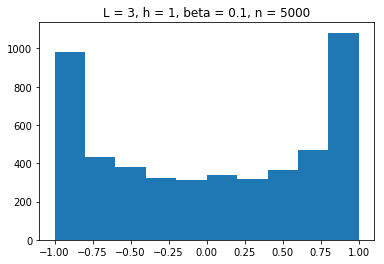

The MCMC estimator for the simple overdamped scheme is 0.02332, with integrated autocorrelation time of 1.07004


In [68]:
n = 5000; beta = 0.1

l = 3; h = 1

S = np.eye(l) 
mag_overdamped = angle_mag_overdamped_sampling(l, n, h, S, beta)  
plt.hist( mag_overdamped ) 
plt.title("L = {}, h = {}, beta = {}, n = {}".format(l, h, beta, n))
plt.show()

tau_mh, mean_mh, sigma_mh = np.round( acor.acor(mag_overdamped), 5)   
print("The MCMC estimator for the simple overdamped scheme is {}, with integrated autocorrelation time of {}".
      format(mean_mh, tau_mh))

## Metropolized

Using the update $Y^{(k+1)}_h \textrm{ ~ }  q(y |x^{(k)}_h)$ with the acceptance probabillity 

$$
p_{acc} =  \textrm{min} \bigg\{1, 
\frac{\pi(Y^{(k)}) q(X^{(k-1)} | Y^{(k)})}
{\pi(X^{(k-1)}) q(Y^{(k)} | X^{(k-1)})}
\bigg\}
$$

As in the previous case, $\mathbf{S = I}$. Therefore, $q(\mathbf{ y |x })$ is the density of the multivariate gaussian $N(\mathbf{x}, 2h\mathbf{I})$. This implies that 
$$
q(X^{(k-1)} | Y^{(k)}) = \frac{1}{\mathcal{Z}}exp(\frac{ \| X^{(k-1)} - Y^{(k)} \|^2}{h}) 
= \frac{1}{\mathcal{Z}}exp(\frac{ \| Y^{(k)} - X^{(k-1)} \|^2}{h}) = q(Y^{(k)} | X^{(k-1)})
$$

So we now have 
$$
p_{acc} =  \textrm{min} \bigg\{1, 
\frac{\pi(Y^{(k)}) }
{\pi(X^{(k-1)})}
\bigg\}
$$
Implementation using the XY model is below. 

In [70]:
def sum_XY(XY): 
    '''
    in terms of angles
    params: 
        XY - the current 1d lattice of the XY model. 
                len L numpy array of angles   
    returns:
        sum_{|j - i| = 1} (cos(theta(i) - theta(j)))
    '''
   
    sum_xy = 0  
    L = len(XY)
    for i in range(L): 
        n1, n2 = get_neighbors(L, i)
        a1 = np.cos(XY[i] - XY[n1])
        a2 = np.cos(XY[i] - XY[n2])
        sum_xy += ( a1 + a2 )  
    return sum_xy

# Test sum_XY: 
XY_test = np.array([0, 0, 0])
print("expected: 6 \t| actual: {}".format(
np.round( sum_XY(XY_test) ) ) )

XY_test = np.array([np.pi / 2, np.pi, np.pi/2])
print("expected: 2 \t| actual: {}".format(
np.round( sum_XY(XY_test) ) ) )

XY_test = np.array([0, np.pi, 0])
print("expected: -2 \t| actual: {}".format(
np.round( sum_XY(XY_test) ) ) )  

def density_XY(XY, beta):
    '''
    in terms of angles
    params: 
        XY - the current 1d lattice of the XY model. 
                len L numpy array of angles   
    returns:
        exp( beta * sum_{|j - i| = 1} (cos(theta(i) - theta(j))) ) 
    '''
    return np.exp(beta * sum_XY(XY))


def get_XY_p_acc(y, x, beta, h): 
    '''
    params: 
        y - XY model Y^(k+1), length L vector of proposed next step in XY model 
        x - XY model X^(k), length L vector of current state 
    returns: 
        acceptance probabillity min{1, ...}
    '''
    
    density_ratio = np.exp(beta * (sum_XY(y) - sum_XY(x)))
    return min([1, density_ratio])  

#test get_XY_p_acc():
print("\nTesting get_XY_p_acc(): \n")
y = np.array([0, 0, 0])

x = np.array([0, 0, 0])
print("expected: 1 \t| actual: {}".format(
np.round( get_XY_p_acc(y, x, beta_test, 1) ) ) )

y = np.array([np.pi / 2, np.pi, np.pi/2])
print("expected: small number \t| actual: {}".format(
np.round( get_XY_p_acc(y, x, beta_test, 1), decimals = 4 ) ) )

y = -1 * np.array([np.pi / 2, np.pi, np.pi/2])
print("expected: same small number \t| actual: {}".format(
np.round( get_XY_p_acc(y, x, beta_test, 1), decimals = 4 ) ) )

expected: 6 	| actual: 6.0
expected: 2 	| actual: 2.0
expected: -2 	| actual: -2.0

Testing get_XY_p_acc(): 

expected: 1 	| actual: 1
expected: small number 	| actual: 0.0183
expected: same small number 	| actual: 0.0183


In [108]:
def metropolis_XY(L, beta, h, S, n):
    '''
    params: 
        L - length of 1d lattice 
        n - number of samples to draw 
        h - scale parameter 
        S - covariance between "points" (each "point" is 2d vector) in lattice 
    returns: 
        - length n list of the cosine of the angle of the magnetization 
        at each step
        - the average acceptance rate over the iterations 
    '''
    mags = []
    acc_rates = [] 
    XY_step = initialize_XY(L)
    for i in range(n):
        y = gaussian_overdamp_step(XY_step, h, S, beta)
        p_acc = get_XY_p_acc(y, XY_step, beta, h) #y proposal, x 
        accept = np.random.choice([True, False], p = [p_acc, 1 - p_acc])
        if accept:
            XY_step = y 
        mags.append(get_mag_angle(XY_step))
        acc_rates.append(p_acc)
    return mags, np.mean(acc_rates) 
        

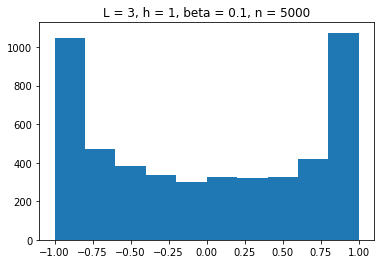

accept rate: 0.8651059498871398
The MCMC estimator for the simple metropolized scheme is -0.00972, with integrated autocorrelation time of 1.54989


In [111]:
n = 5000; beta = 0.1

l = 3; h = 1; S = np.eye(l)

metro_mags, ar = metropolis_XY(l, beta, h, S, n)
plt.hist( metro_mags ) 
plt.title("L = {}, h = {}, beta = {}, n = {}".format(l, h, beta, n))
plt.show()
print("accept rate: {}".format(ar))

tau_mh, mean_mh, sigma_mh = np.round( acor.acor(metro_mags), 5)   
print("The MCMC estimator for the simple metropolized scheme is {}, with integrated autocorrelation time of {}".
      format(mean_mh, tau_mh))


## Metropolized vs un-Metropolized

For fixed $\beta$ and samples drawn: 

In [198]:
L = [3, 6, 9, 12, 15]
scales = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
num_samples = 2000

for l in L:
    S = np.eye(l)
    for h in scales:  
        mag_overdamped = angle_mag_overdamped_sampling(l, num_samples, h, S, beta)  
        metro_mags, ar = metropolis_XY(l, beta, h, S, num_samples)
        
        tau, mean, sigma = acor.acor(mag_overdamped)
        tau_m, mean_m, sigma_m = acor.acor(metro_mags)

        print("h: {}\t| L: {} \t| Metro IAT: {}\t| Non IAT: {}".
          format(h, l, np.round(tau_m, 3), np.round(tau, 3)))


h: 0.001	| L: 3 	| Metro IAT: 111.962	| Non IAT: 93.055
h: 0.01	| L: 3 	| Metro IAT: 19.087	| Non IAT: 25.404
h: 0.05	| L: 3 	| Metro IAT: 6.506	| Non IAT: 11.627
h: 0.1	| L: 3 	| Metro IAT: 3.369	| Non IAT: 5.491
h: 0.5	| L: 3 	| Metro IAT: 2.479	| Non IAT: 1.137
h: 1	| L: 3 	| Metro IAT: 1.369	| Non IAT: 0.776
h: 0.001	| L: 6 	| Metro IAT: 52.518	| Non IAT: 24.624
h: 0.01	| L: 6 	| Metro IAT: 5.9	| Non IAT: 17.958
h: 0.05	| L: 6 	| Metro IAT: 11.166	| Non IAT: 4.617
h: 0.1	| L: 6 	| Metro IAT: 4.157	| Non IAT: 2.299
h: 0.5	| L: 6 	| Metro IAT: 1.338	| Non IAT: 0.961
h: 1	| L: 6 	| Metro IAT: 1.406	| Non IAT: 0.876
h: 0.001	| L: 9 	| Metro IAT: 42.601	| Non IAT: 20.532
h: 0.01	| L: 9 	| Metro IAT: 21.713	| Non IAT: 8.15
h: 0.05	| L: 9 	| Metro IAT: 6.753	| Non IAT: 3.26
h: 0.1	| L: 9 	| Metro IAT: 2.583	| Non IAT: 1.999
h: 0.5	| L: 9 	| Metro IAT: 1.767	| Non IAT: 1.178
h: 1	| L: 9 	| Metro IAT: 1.449	| Non IAT: 1.339
h: 0.001	| L: 12 	| Metro IAT: 59.569	| Non IAT: 36.787
h: 0.01	| L

As $h$ increases, IAT decreases - which makes sense this means more variance in our overdamped step. The metropolized version, as expected, has a higher IAT than the overdamped scheme, as the possibillity of rejection makes the chain evolve slower in exchange for a better estimator. 

# 56) Hybrid Monte Carlo for XY Model

Write a routine to sample the XY model described in Exercise
55 using Algorithm 4 both with and without the Metropolis accept/reject step.
You’re free to choose the other parameters of the algorithm (K, J, n, and h)
as you like (but be clear about your choices). Compare the results to those of
Exercise 55 using integrated autocorrelation time of the cosine of the angle of
magnetization as your measure of efficiency. Make sure you are accounting
correctly for the cost to generate each step of the chain (e.g. as measured by
the number of evaluations of r log.

For simplicity, let 

$$
K(\tilde{x}) = \frac{ \|x\|^2 }{2} \\ 
n = 1 \\ 
h = 1 \\
\hat{J}_{\tilde{L} x \tilde{L}} = I \\
J = 
\begin{bmatrix}
    0 & I \\
    -I & 0
\end{bmatrix}
$$


which should yield the same performance as the first overdamped scheme: 

$$
X^{(k+1)}_h = X^{(k)}_h + h\mathbf{S}\nabla^T\textrm{log}(\pi(X^{(k)}_h)) + \sqrt{2h\mathbf{S}} \xi^{k+1}
$$

For our choice of $K(\tilde{x})$, our density of $\tilde{Y}^{(k-1)}$, a length $\tilde{L}$ vector (in the context of the XY model) will then just be generated from the standard normal.  

We are now ready to implement Hybrid MC. Let's start with some helper functions (specifically velocity verlet): 

In [90]:
def velocity_verlet_XY(y_hat, y_tilde, J_hat, h, beta,
                      identity = True):
    '''
    Assumes constant J
    params: 
        y_hat - length L_hat numpy array model, lattice values 
        y_tilde - length L_tilde numpy array model, conjugate values
        h - float, scale parameter 
        J_hat - For simplicity, L_hat x L_hat square np matrix 
        beta - inverse temp constant in XY model
        identity - if J_hat = I, then True. Save some comp time 
    returns: 
        - y_hat_step, L_hat numpy array of XY model 
            after one step of velocity verlet
        - y_hat_tilde, L_tilde numpy array of XY model 
            after one step of velocity verlet  
    '''

    if identity: 
        y_tilde_prime = y_tilde + 0.5 * h * log_gradient(y_hat, beta)
        y_hat_step = y_hat + h * y_tilde_prime #gradient of l2(y_tilde_prime) 
        y_tilde_step = y_tilde_prime + 0.5 * h * log_gradient(y_hat_step, beta)
    else: 
        #this part hasn't been checked yet, but since we are using J_hat = I anyways, we can ignore this part 
        y_tilde_prime = y_tilde + 0.5 * h * np.dot(J_hat, log_gradient(y_hat, beta))
        y_hat_step = y_hat + h * np.dot( J_hat, (y_tilde_prime) )#gradient of l2(y_tilde_prime) 
        y_tilde_step = y_tilde_prime + h/2 * np.dot(J_hat, log_gradient(y_hat_step, beta))

    return y_hat_step, y_tilde_step

# Test velocity verlet scheme
L_hat = 3; L_tilde = 3
y_hat = np.array( [0, 0, 0] ) 
y_tilde = np.array( [0, 0, 0] )
J_hat = np.eye(L_hat)
h = 1

vv_hat, vv_tilde  = velocity_verlet_XY(y_hat, y_tilde, J_hat, h, beta_test,
                  identity = True) 
print("expected: [0, 0, 0, 0, 0, 0] \t| actual: {}".format( np.append( vv_hat, vv_tilde ) ) ) 

y_hat = np.array( [np.pi/2, np.pi, np.pi/2] ) 
y_tilde = np.array( [0, 0, 0] )
vv, _ = np.round( velocity_verlet_XY(y_hat, y_tilde, J_hat, h, beta_test,
                  identity = True), 3 ) 
exp_y_hat = np.round( [np.pi/2 + 0.5, np.pi - 1, np.pi/2 + 0.5], 3)
print("expected y_hat: {} \t| actual y_hat: {}".format(exp_y_hat, vv)) #y_tilde gets tossed anyways...

def velocity_verlet_rep(y_hat, y_tilde, n, J_hat, h, beta,
                      identity = True):
    '''
    Assumes constant J 
    params: 
        y_hat - length L_hat numpy array model, lattice values 
        y_tilde - length L_tilde numpy array model, conjugate values
        n - int, number of iterations of velocity verlet scheme 
        h - float, scale parameter 
        J_hat - For simplicity, L_hat x L_hat square np matrix 
        beta - inverse temp constant in XY model
        identity - if J_hat = I, then True. Save some comp time 
    returns: 
        - returns: 
        - y_hat_step, length L_hat numpy array of XY model 
            after n steps of velocity verlet
        - y_hat_tilde, length L_tilde numpy array of XY model 
            after n steps of velocity verlet  
    '''
    y_hat_step = y_hat; y_tilde_step = y_tilde 
    for i in range(n): 
        y_hat_step, y_tilde_step = velocity_verlet_XY(y_hat_step, y_tilde_step, J_hat, h, beta_test,
                  identity = True)
    return y_hat_step, y_tilde_step

expected: [0, 0, 0, 0, 0, 0] 	| actual: [ 0.  0.  0.  0.  0.  0.]
expected y_hat: [ 2.071  2.142  2.071] 	| actual y_hat: [ 2.071  2.142  2.071]


In [91]:
def density_ratio_XY_hybrid(y_hat, y_tilde, x_hat, x_tilde, beta):
    '''
    pi_H(y) / pi(x);
    y is proposal, x is previous
    params:
        y_hat - length L_hat numpy array of XY model (velocity verlet)
        y_tilde - length L_tilde numpy array of conj vals (velocity verlet)
        x_hat - length L_hat numpy array of XY model (previous)
        x_tilde - length L_tilde numpy array of conj vals (velocity verlet)
        beta - float, you know
    '''
    hat_ratio = np.exp(beta * (sum_XY(y_hat) - sum_XY(x_hat)))
    tilde_ratio = np.exp( -0.5 * ( np.sum(y_tilde**2) - np.sum(x_tilde**2) ) )  
    return min([1, hat_ratio * tilde_ratio]) 

In [75]:
def hybrid_mc_XY(num_samples, L_hat, L_tilde, beta, h, n,
                J_hat, identity = True,
                 metropolize = False):
    '''
    Note that we express L = L_hat + L_tilde 
    params: 
        num_samples - number of samples to draw 
        L_hat - length of XY model, 1d lattice
        L_tilde - length of conjugate values added to 1d lattice
        n - number of iterations of velocity verlet scheme 
        h - scale parameter 
        J_hat - L_hat x L_hat np matrix
        identity - True if J_hat = I 
        metropolize - True if you use p_acc
        beta - inverse temp coeff 
    returns: 
        - length num_samples numpy array representing the cosine of the angle of mag 
                for the XY model on length L_hat lattice 
    ''' 

    L = L_hat + L_tilde
    XY_step = initialize_XY(L_hat)
    
    mags = []
    acc_rates = [] 

    for i in range(num_samples):
        y_tilde = np.random.normal(size = L_tilde)
        y_hat_step, y_tilde_step = velocity_verlet_rep(XY_step, y_tilde, n, J_hat, h, beta,
                      identity)
        
        if metropolize: 
            p_acc = density_ratio_XY_hybrid(y_hat_step, y_tilde_step,
                                           XY_step, y_tilde, beta)
            accept = np.random.choice([True, False], p = [p_acc, 1 - p_acc])
            if accept:
                XY_step = y_hat_step
            acc_rates.append(p_acc)
        else: 
            XY_step = y_hat_step 
            
        mags.append(get_mag_angle(XY_step))
     
    if metropolize: 
        return mags, np.mean(acc_rates)
    return mags 

## Non Metropolized 

Without reject step: 

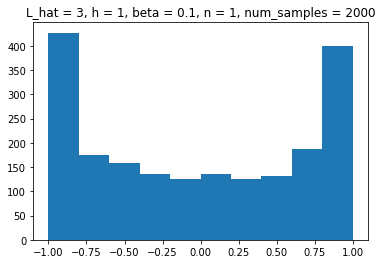

In [195]:
num_samples = 2000 
n = 1 
beta = 0.1 

mags_hybrid_mc_XY = hybrid_mc_XY(num_samples, L_hat, L_tilde, beta, h, n,
                J_hat, identity = True,
                 metropolize = False)
plt.hist( mags_hybrid_mc_XY ) 
plt.title("L_hat = {}, h = {}, beta = {}, n = {}, num_samples = {}".
          format(L_hat, h, beta, n, num_samples))
plt.show()

## Metropolized 

Acceptance probabillity: 

$$
p_{acc} = min\bigg\{ 1, \frac{\pi_{H}(Y^{(k)})}
{\pi_H(\hat{X}^{(k-1)}, \tilde{Y}^{(k-1)})} \bigg\}
$$

Where in the setting $K = \|\tilde{x}\|^2$, 

$$
\pi_H \propto \pi(\hat{x}) \phi(\tilde{x})
$$

Where $\phi$ is the density of the standard multivariate normal

If rejected, $\hat{X}^{(k)} = \hat{X}^{(k-1)}$. Conjugate terms are changed but since we toss them at each iteration we do not need to pay much attention to them. 

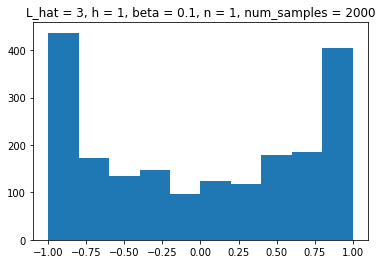

acceptance rate: 0.7290440086638525


In [196]:
mags_hybrid_mc_metro_XY, ar = hybrid_mc_XY(num_samples, L_hat, L_tilde, beta, h, n,
                J_hat, identity = True,
                 metropolize = True)
plt.hist( mags_hybrid_mc_metro_XY ) 
plt.title("L_hat = {}, h = {}, beta = {}, n = {}, num_samples = {}".
          format(L_hat, h, beta, n, num_samples))
plt.show()

print("acceptance rate: {}".format(ar))

## Metropolized vs Un Metropolized

For $\beta = 0.1$, 2000 samples, and $\hat{L} = \tilde{L} = 3$

In [202]:
np.random.seed(56)
scales = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
for h in scales:
    mags_hybrid_mc_XY = hybrid_mc_XY(num_samples, L_hat, L_tilde, beta, h, n,
                J_hat, identity = True,
                 metropolize = False)
    mags_hybrid_mc_metro_XY, ar = hybrid_mc_XY(num_samples, L_hat, L_tilde, beta, h, n,
                J_hat, identity = True,
                 metropolize = True)
    tau_mh, mean_mh, sigma_mh = np.round( acor.acor(mags_hybrid_mc_XY), 3)   
    tau_mh_metro, mean_mh, sigma_mh = np.round( acor.acor(mags_hybrid_mc_metro_XY), 3)
    
    print("h: {}\t| Metro IAT: {}\t| Non IAT: {}".
      format(h, tau_mh_metro, tau_mh))
    

h: 0.001	| Metro IAT: 103.165	| Non IAT: 50.541
h: 0.01	| Metro IAT: 115.919	| Non IAT: 98.28
h: 0.05	| Metro IAT: 27.143	| Non IAT: 67.09
h: 0.1	| Metro IAT: 34.867	| Non IAT: 23.96
h: 0.5	| Metro IAT: 8.23	| Non IAT: 4.384
h: 1	| Metro IAT: 2.116	| Non IAT: 1.408


As expected, IAT of metropolis is generally larger than the  un metropolized counterpart, and as $h$ gets largers, IAT falls. In comparison to 55), we would be prefer the latter since it costs less and gives a reasonable estimate. (IAT also seems to be smaller for 55)

# 57) Underdamped Langevin 

Helper functions below. (For Frictional Velocity Verlet - 5.23) 


In [269]:
def gaussian_fvv( x_hat_0, x_tilde_0, h, gamma, beta,
       J_hat, identity = True): 
    '''
    Eq. 5.23), Assumes constant J_hat, L_hat iid gaussians xi,
    , K = ||x_tilde||^2/2, 
    , block matrix S = 0 & 0 \\   
                       0 & gamma * I 
    one iteration of frictional velocity verlet scheme 
    params: 
        x_hat_0 - length L_hat numpy array model, lattice values 
        x_tilde_0 - length L_tilde numpy array model, conjugate values
        h - float, scale parameter 
        beta - inverse temp coeff in XY density 
        J_hat - For simplicity, L_hat x L_hat square np matrix 
        identity - if J_hat = I, then True. Save some comp time 
    returns: 
        - x_hat_step, L_hat numpy array of XY model 
            after one step of fric velocity verlet
        - x_hat_tilde, L_tilde numpy array of XY model 
            after one step of fric velocity verlet  
    '''
    h2 = h/2 
    L_hat = len(x_tilde_0)
    L_tilde = len(x_hat_0)
    
    if identity: 
        x_tilde_prime = x_tilde_0 + h2 * log_gradient(x_hat_0, beta)
        x_hat_prime = x_hat_0 + h2 * x_tilde_prime #gradient of l2(y_tilde_prime) 
        
        fc = np.exp(-gamma * h)
        xi = np.random.normal(size = L_tilde)
        x_tilde_prime2 = fc * x_tilde_prime + np.sqrt(1 - fc**2) * xi
        
        x_hat_step = x_hat_prime + h2 * x_tilde_prime2
        x_tilde_step = x_tilde_prime2 + h/2 * log_gradient(x_hat_step, beta)
        return x_hat_step, x_tilde_step
    
    else: 
        lg1 = log_gradient(x_hat_0, beta).reshape(L_hat, 1)
        x_tilde_prime = x_tilde_0 + h2 * np.dot(J_hat.transpose, lg1)  
        x_hat_prime = x_hat_0 + h2 * np.dot(J_hat, x_tilde_prime) #gradient of l2(y_tilde_prime) 
        
        fc = np.exp(-gamma * h)
        xi = np.random.normal(size = L_hat)
        x_tilde_prime2 = fc * x_tilde_prime + np.sqrt(1 - fc**2) * xi
        
        x_hat_step = x_hat_prime + h2 * np.dot(J_hat, x_tilde_prime2)
        
        lg2 = log_gradient(x_hat_step, beta).reshape(L_hat, 1)
        x_tilde_step = x_tilde_prime2 + h2 * np.dot(J_hat.transpose, lg2)
        return x_hat_step, x_tilde_step

    
def gaussian_fvv_rep(x_hat_0, x_tilde_0, h, gamma, beta, n
       J_hat, identity = True):
    '''
    Assumes constant J 
    returns: 
        - x_hat_step, L_hat numpy array of XY model 
            after n steps of fric velocity verlet
        - x_hat_tilde, L_tilde numpy array of XY model 
            after n steps of fric velocity verlet  
    '''
    x_hat_step = x_hat; x_tilde_step = x_tilde 
    for i in range(n): 
        x_hat_step, x_tilde_step = gaussian_fvv(x_hat_0, x_tilde_0, h, gamma, beta, n, J_hat, identity)
    return x_hat_step, x_tilde_step

SyntaxError: invalid syntax (<ipython-input-269-bd6d639529b9>, line 55)

In [257]:
# Test frictional velocity verlet scheme
L_hat = 3; L_tilde = 3
y_hat = np.array( [0, 0, 0] ) 
y_tilde = np.array( [0, 0, 0] )
J_hat = np.eye(L_hat); h = 1; gamma = 0.5

fvv_hat, fvv_tilde  = gaussian_fvv( y_hat, y_tilde, h, gamma, test_beta,
       J_hat, identity = True) #should match velocity verlet since gamma = 0  
print("expected: [0, 0, 0, 0, 0, 0] \t| actual: {}".format( np.append( fvv_hat, fvv_tilde ) ) ) 

y_hat = np.array( [np.pi/2, np.pi, np.pi/2] ) 
y_tilde = np.array( [0, 0, 0] )
fvv_hat, fvv_tilde  = gaussian_fvv( y_hat, y_tilde, h, gamma, test_beta,
       J_hat, identity = True) #should match velocity verlet since gamma = 0
exp_y_hat = np.round( [np.pi/2 + 0.5, np.pi - 1, np.pi/2 + 0.5], 3)
print("expected y_hat: {} \t| actual y_hat: {}".format(exp_y_hat, fvv_hat)) #y_tilde gets tossed anyways...

expected: [0, 0, 0, 0, 0, 0] 	| actual: [-0.28645935 -0.07000111 -0.60562178 -0.62241847 -0.5025756  -0.79917042]
expected y_hat: [ 2.071  2.142  2.071] 	| actual y_hat: [ 2.05392024  2.255542    1.88345958]


In [208]:
def transition_density(y_hat, y_tilde, x_hat, x_tilde,
          h, gamma, J_hat, identity = True): 
    '''
    r(x, y) = ... 
    '''
    egh = np.exp(-gamma * h)
    var = 2 * (1 - egh**2)
    d = y_tilde - egh * x_tilde
    g = (egh * log_gradient(x_hat, beta) + log_gradient(y_hat, beta))
    if identity: 
        mu = 0.5 * h * g
    else: 
        mu = 0.5 * h * np.dot(J_hat.transpose, g.reshape(len(G), 1))
    return np.exp(-np.sum((d - mu)**2) / var)

gamma_test = 0.5
L_test = 3 
y_hat = np.array( [np.pi] * L_test )
y_tilde = np.array( [np.pi] * L_test )
x_hat = np.array( [np.pi] * L_test )
x_tilde = np.array( [np.pi] * L_test )
print("Quick Test: {}".format(transition_density(y_hat, y_tilde, x_hat, x_tilde,
                  h, gamma_test, J_hat, True)))

x_hat = np.array( [np.pi/2] * L_test )
x_tilde = np.array( [np.pi/2] * L_test )
print("Quick Test: {}".format(transition_density(y_hat, y_tilde, x_hat, x_tilde,
                  h, gamma_test, J_hat, True)))


Quick Test: 0.6907114828855941
Quick Test: 2.6395115302462588e-19


In [218]:
def vflip_p_acc(y_hat, y_tilde, x_hat, x_tilde, beta,
                h, gamma, J_hat, identity): 
    '''
    as outlined in algo 6
    params: 
        
    returns: 
        min{1, ...}
    '''
    dr = density_ratio_XY_hybrid(y_hat, y_tilde, x_hat, x_tilde, beta)
    tr_step = transition_density(y_hat, -y_tilde, x_hat, -x_tilde,
                                h, gamma, J_hat, identity)
    tr = transition_density(x_hat, x_tilde, y_hat, y_tilde,
                                h, gamma, J_hat, identity)
    return min([1, dr * tr_step / tr])

x_hat = np.array( [np.pi] * L_test )
x_tilde = np.array( [np.pi ] * L_test )
print("Quick Test: {}".format(vflip_p_acc(y_hat, y_tilde, x_hat, x_tilde, beta,
                h, gamma, J_hat, True) ) )

Quick Test: 1


In [159]:
def underdamped_langevin_XY( 
    num_samples, L_hat, L_tilde, beta, h,
                J_hat, gamma, identity = True, 
                 metropolize = False):
    '''
    Note that we express L = L_hat + L_tilde 
    params: 
        num_samples - number of samples to draw 
        L_hat - length of XY model, 1d lattice
        L_tilde - length of conjugate values added to 1d lattice
        h - scale parameter 
        gamma - frictional coeff 
        J_hat - L_hat x L_hat np matrix
        identity - True if J_hat = I 
        metropolize - True if you use p_acc
        beta - inverse temp coeff 
    returns: 
        - length num_samples numpy array representing the cosine of the angle of mag 
                for the XY model on length L_hat lattice 
    ''' 
    x_hat = initialize_XY(L_hat)
    x_tilde = initialize_XY(L_tilde)
    
    mags = []
    acc_rates = [] 

    for i in range(num_samples):
        y_hat, y_tilde = gaussian_fvv( x_hat, x_tilde, h, 
                                        gamma, beta,
                                        J_hat, identity = True) 
        if metropolize: 
            p_acc = vflip_p_acc(y_hat, y_tilde, x_hat, y_tilde, 
                beta, h, gamma, J_hat, identity)
            accept = np.random.choice([True, False], p = [p_acc, 1 - p_acc])
            if accept:
                x_hat = y_hat
                x_tilde = y_tilde
            else: 
                x_tilde = -x_tilde #velocity flip 

            acc_rates.append(p_acc)
        else: 
            x_hat = y_hat 
            
        mags.append(get_mag_angle(x_hat))
     
    if metropolize: 
        return mags, np.mean(acc_rates)
    return mags 

## un - Metropolized 

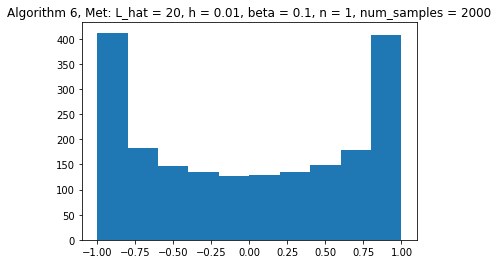

In [262]:
num_samples = 2000 
n = 1 
beta = 0.1 
gamma = 0.1

mags_flip_XY = underdamped_langevin_XY(num_samples, L_hat, L_tilde, beta, h,
                J_hat, gamma, identity = True, 
                 metropolize = False)
plt.hist( mags_flip_XY ) 
plt.title("Algorithm 6, Met: L_hat = {}, h = {}, beta = {}, n = {}, num_samples = {}".
          format(L_hat, h, beta, n, num_samples))
plt.show()

## Metropolized

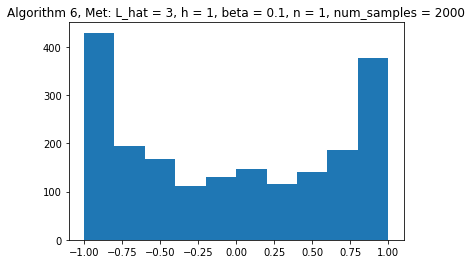

acceptance rate: 0.8930049581911996


In [166]:
mags_flip_XY_met, ar = underdamped_langevin_XY(num_samples, L_hat, L_tilde, beta, h,
                J_hat, gamma, identity = True, 
                 metropolize = True)
plt.hist( mags_flip_XY_met ) 
plt.title("Algorithm 6, Met: L_hat = {}, h = {}, beta = {}, n = {}, num_samples = {}".
          format(L_hat, h, beta, n, num_samples))
plt.show()
print("acceptance rate: {}".format(ar))

## Metropolized vs un Metropolized Velocity Flip

For fixed $\beta = 0.1$, $L = \hat{L} + \tilde{L} = 20$ 

In [265]:
num_samples = 2000
L_hat = 5; L_tilde = 5
gammas = [0] 
for gamma in gammas: 
    for h in scales:  
        mags_flip_XY = underdamped_langevin_XY(num_samples, L_hat, L_tilde, beta, h,
                J_hat, gamma, identity = True, 
                 metropolize = False)
        #mags_flip_XY_met, ar = underdamped_langevin_XY(num_samples, L_hat, L_tilde, beta, h,
        #        J_hat, gamma, identity = True, 
        #         metropolize = True)
        
        tau, mean, _ = acor.acor(mags_flip_XY)
        #tau_m, mean_m, _ = acor.acor(mags_flip_XY_met)

        print("h: {}\t| gamma: {} \t| Metro IAT: {}\t| Non IAT: {}".
          format(h, gamma, np.round(tau_m, 3), np.round(tau, 3)))


h: 0.001	| gamma: 0 	| Metro IAT: 0.081	| Non IAT: 15.405
h: 0.01	| gamma: 0 	| Metro IAT: 0.081	| Non IAT: 2.675
h: 0.05	| gamma: 0 	| Metro IAT: 0.081	| Non IAT: 0.906


RuntimeError: D was negative in acor. Can't calculate sigma.

Meh... This bug has been going on for a little bit and couldn't figure it out. So for my final analysis, I'm going to be a bit biased and go with 55), since it runs the fastest and didn't run into any bugs. 